# Privacy evaluation 

This tutorial explains how to evaluate the privacy of synthetic smart meter data. This notebook is based on the Faraday architecture, trained on Low Carbon London dataset.

- For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).
- For more information on evaluation method, refer to the paper by Centre for Net Zero on [Defining 'Good': Evaluation Framework for Synthetic Smart Meter Data
](https://arxiv.org/abs/2407.11785). 

### Pre-requisites

1. If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households).
2. If you haven't already, you need to first train a model (refer to the `faraday_tutorial.ipynb` notebook).


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import logging
logging.basicConfig(level=logging.INFO)

# 💿 Loading LCL Data

In [3]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

# Original training data with no outliers
dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm.setup()

In [4]:
# Training data with implausible outliers injected for privacy attacks
dm_with_outliers = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=200, n_samples=20000, outlier_path=outlier_path)
dm_with_outliers.setup()

In [5]:
# Holdout data
holdout_path = Path("../../data/processed/historical/holdout/lcl_data.csv")
dm_holdout = LCLDataModule(data_path=holdout_path, stats_path=stats_path, batch_size=200, n_samples=20000)
dm_holdout.setup()

# 🤖 Load Pretrained Faraday model

In [6]:
from opensynth.models.faraday.model import FaradayModel
import numpy as np
import torch

In [12]:
faraday1500 = torch.load("faraday_model_1500.pt", weights_only=False)
faraday150 = torch.load("faraday_model_150.pt", weights_only=False)
faraday50 = torch.load("faraday_model_50.pt", weights_only=False)
faraday10 = torch.load("faraday_model_10.pt", weights_only=False)
faraday5 = torch.load("faraday_model_10.pt", weights_only=False)
faraday1 = torch.load("faraday_model_1.pt", weights_only=False)

# 1️⃣ Reconstruction Attack

As described in the Defining good paper, the reconstruction attack involves:

1. Train the generative model with implausible outliers injected (100)
2. Generate a random sample of data from the injected outliers (10000)
3. Calculate the pairwise euclidean distances of each injected outlier with every sample in the batch of randomly generated data.
4. Aggregate the results to retrieve the nearest generated sample for each outlier, and express the distance as a ratio of the norm of the outlier's vector.
5. Visualise results in a cumulative distribution function.

### 🏭 Create Reconstruction Attack Dataset

In [13]:
from opensynth.evaluation.privacy import reconstruction_attack

faraday1500_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday1500, dm=dm_with_outliers, n_samples=10000
)

faraday150_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday150, dm=dm_with_outliers, n_samples=10000
)

faraday50_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday50, dm=dm_with_outliers, n_samples=10000
)

faraday10_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday10, dm=dm_with_outliers, n_samples=10000
)
faraday5_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday5, dm=dm_with_outliers, n_samples=10000
)
faraday1_attack_dataset = reconstruction_attack.create_attack_dataset(
    model=faraday1, dm=dm_with_outliers, n_samples=10000
)

### 🧮 Calculating pair-wise euclidean distances

In [14]:

faraday1500_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday1500_attack_dataset.outlier_samples,
    fake = faraday1500_attack_dataset.synthetic_samples,
    group_min=True
)

faraday150_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday150_attack_dataset.outlier_samples,
    fake = faraday150_attack_dataset.synthetic_samples,
    group_min=True
)

faraday50_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday50_attack_dataset.outlier_samples,
    fake = faraday50_attack_dataset.synthetic_samples,
    group_min=True
)

faraday10_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday10_attack_dataset.outlier_samples,
    fake = faraday10_attack_dataset.synthetic_samples,
    group_min=True
)

faraday5_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday5_attack_dataset.outlier_samples,
    fake = faraday5_attack_dataset.synthetic_samples,
    group_min=True
)

faraday1_distance_norm = reconstruction_attack.calculate_distance_norm(
    real = faraday1_attack_dataset.outlier_samples,
    fake = faraday1_attack_dataset.synthetic_samples,
    group_min=True
)

INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating vector norm..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Calculating pairwise euclidean distance..
INFO:opensynth.evaluation.privacy.reconstruction_attack:Converting wide to long table..
INFO:opens

### 📈 Plotting cumulative distribution function

In the defining good paper, it is recommended that threshold ratio be set to 0.3. This is analogous to saying that for a outlier profile with daily total consumption of 30kwh, a generated profile with total consumption within 30% (21±9kwh) is sufficient to render that outlier compromised.

Using this threshold, we can see that GMMs trained with 1500 clusters, about 16.5% of outliers would have rended about 53% of outliers successfully reconstructed, whilst GMM trained with only 1 cluster is very private. All synthetic data generated lies outside of 0.6 X norm of injected outliers. 

(0.0, 1.0)

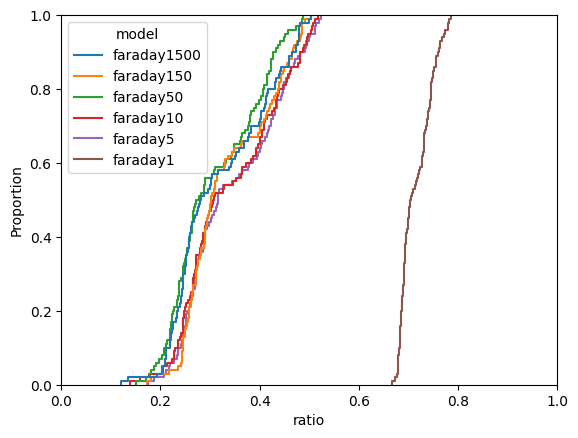

In [15]:
import pandas as pd
import seaborn as sns


faraday1500_distance_norm["model"] = "faraday1500"
faraday150_distance_norm["model"] = "faraday150"
faraday50_distance_norm["model"] = "faraday50"
faraday10_distance_norm["model"] = "faraday10"
faraday5_distance_norm["model"] = "faraday5"
faraday1_distance_norm["model"] = "faraday1"

df_reconstruction_attack_results = pd.concat([
    faraday1500_distance_norm,
    faraday150_distance_norm,
    faraday50_distance_norm,
    faraday10_distance_norm,
    faraday5_distance_norm,
    faraday1_distance_norm
]).reset_index(drop=True)

sns.ecdfplot(data=df_reconstruction_attack_results, x="ratio", hue="model")
plt.xlim(0, 1)

# 2️⃣ Membership Inference Attacks

As described in the Defining good paper, the membership inference attack involves:

1. Train a discriminator that attempts to distinguish between synthetically generated data and the holdout set (real data but unseen during training of the generative model.)
2. Create an 'attack dataset' that comprises of 1) Seen outliers during the training of the generative model 2) Unseen outliers but belonging to the same distribution to the seen outliers, and 3) Unseen outliers but belonging to a different distribution. A random guess would yield a precision of 33%.
3. Use the trained discriminative model to predict on the attack dataset and report on the precision, and check that it is no better than random guess.

### 🏭 Create Membership Inference Attack Dataset

In [16]:
from opensynth.evaluation.privacy import membership_inference_attack as mia
import pytorch_lightning as pl

dm_mia_faraday1500 = mia.MembershipInferenceDataModule(
    model=faraday1500,
    dm_train=dm_with_outliers,
    dm_holdout=dm_holdout,
    batch_size=5000
)
dm_mia_faraday1500.setup("")

dm_mia_faraday150 = mia.MembershipInferenceDataModule(
    model=faraday150,
    dm_train=dm_with_outliers,
    dm_holdout=dm_holdout,
    batch_size=5000
)
dm_mia_faraday150.setup("")

dm_mia_faraday50 = mia.MembershipInferenceDataModule(
    model=faraday50,
    dm_train=dm_with_outliers,
    dm_holdout=dm_holdout,
    batch_size=5000
)
dm_mia_faraday50.setup("")

dm_mia_faraday1 = mia.MembershipInferenceDataModule(
    model=faraday1,
    dm_train=dm_with_outliers,
    dm_holdout=dm_holdout,
    batch_size=5000
)
dm_mia_faraday1.setup("")

INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.2079 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.0000 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.2079 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.0000 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.2079 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.0000 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.2079 and mean_factor: 20.0000
INFO:opensynth.datasets.low_carbon_london.preprocess_lcl:🎲 Generating unseen outliers with mean:0.0000 a

### 🤖 Train discriminator models

#### GMM with 1500 Clusters

In [17]:
mia_model_faraday1500 = mia.MembershipInferenceModel(learning_rate=0.02, input_size=48)
train_dl = dm_mia_faraday1500.train_dataloader()
eval_dl = dm_mia_faraday1500.eval_dataloader()
trainer = pl.Trainer(max_epochs=100, accelerator="auto", strategy="auto")
trainer.fit(mia_model_faraday1500, train_dataloaders=train_dl, val_dataloaders=eval_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | loss_fn | 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/shengchai/.local/share/virtualenvs/OpenSynth-EhRIPYd3/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 28.42it/s, v_num=68, Eval BCE Loss=0.836, Eval Accuracy=0.688, Train BCE Loss=0.346, Train Accuracy=0.856]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 26.42it/s, v_num=68, Eval BCE Loss=0.836, Eval Accuracy=0.688, Train BCE Loss=0.346, Train Accuracy=0.856]


#### GMM with 150 Clusters

In [18]:
mia_model_faraday150 = mia.MembershipInferenceModel(learning_rate=0.02, input_size=48)
train_dl = dm_mia_faraday150.train_dataloader()
eval_dl = dm_mia_faraday150.eval_dataloader()
trainer = pl.Trainer(max_epochs=100, accelerator="auto", strategy="auto")
trainer.fit(mia_model_faraday150, train_dataloaders=train_dl, val_dataloaders=eval_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss         | 0      | train
1 | model   | MembershipInferenceModule | 2.2 K  | train
--------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 17.61it/s, v_num=69, Eval BCE Loss=0.524, Eval Accuracy=0.783, Train BCE Loss=0.351, Train Accuracy=0.847]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s, v_num=69, Eval BCE Loss=0.524, Eval Accuracy=0.783, Train BCE Loss=0.351, Train Accuracy=0.847]


#### GMM with 50 Clusters

In [19]:
mia_model_faraday50 = mia.MembershipInferenceModel(learning_rate=0.02, input_size=48)
train_dl = dm_mia_faraday50.train_dataloader()
eval_dl = dm_mia_faraday50.eval_dataloader()
trainer = pl.Trainer(max_epochs=100, accelerator="auto", strategy="auto")
trainer.fit(mia_model_faraday50, train_dataloaders=train_dl, val_dataloaders=eval_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss         | 0      | train
1 | model   | MembershipInferenceModule | 2.2 K  | train
--------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s, v_num=70, Eval BCE Loss=0.409, Eval Accuracy=0.844, Train BCE Loss=0.352, Train Accuracy=0.845]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s, v_num=70, Eval BCE Loss=0.409, Eval Accuracy=0.844, Train BCE Loss=0.352, Train Accuracy=0.845]


#### GMM with only 1 Cluster

In [20]:
mia_model_faraday1 = mia.MembershipInferenceModel(learning_rate=0.02, input_size=48)
train_dl = dm_mia_faraday1.train_dataloader()
eval_dl = dm_mia_faraday1.eval_dataloader()
trainer = pl.Trainer(max_epochs=100, accelerator="auto", strategy="auto")
trainer.fit(mia_model_faraday1, train_dataloaders=train_dl, val_dataloaders=eval_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss         | 0      | train
1 | model   | MembershipInferenceModule | 2.2 K  | train
--------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s, v_num=71, Eval BCE Loss=0.576, Eval Accuracy=0.810, Train BCE Loss=0.293, Train Accuracy=0.881]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 17.58it/s, v_num=71, Eval BCE Loss=0.576, Eval Accuracy=0.810, Train BCE Loss=0.293, Train Accuracy=0.881]


### 🎯 Check Precision

Results show that Faraday trained with 1500 and 150 GMM Clusters failed membership inference attacks, whilst 50 GMM Clusters and 1 GMM cluster passed. However we also see that 50 GMM cluster failed the reconstruction attack, hence it is not safe for release.

In the `faraday_tutorial.ipynb` notebook, we also see that GMM with only 1 clusters is less accurate compared to 50, 150 and 1500 clusters. There is therefore a trade-off between privacy and fidelity. Perhaps there is a cluster between 1 and 50 that could meet both privacy and fidelity requirements.

In [21]:
df_mia_results_faraday1500 = mia.get_mia_predictions(mia_model_faraday1500, dm_mia_faraday1500)
mia.print_mia_results(df_mia_results_faraday1500)

Segment: Precision: 0.40 +/- 0.06,
F1: 0.40, Acc: 0.60,
True Positives: 40,
False Positive: 60,
Total N: 300,
Total Positive: 100,
Random Precision : 0.33,


In [22]:
df_mia_results_faraday150 = mia.get_mia_predictions(mia_model_faraday150, dm_mia_faraday150)
mia.print_mia_results(df_mia_results_faraday150)

Segment: Precision: 0.45 +/- 0.06,
F1: 0.45, Acc: 0.63,
True Positives: 45,
False Positive: 55,
Total N: 300,
Total Positive: 100,
Random Precision : 0.33,


In [23]:
df_mia_results_faraday50 = mia.get_mia_predictions(mia_model_faraday50, dm_mia_faraday50)
mia.print_mia_results(df_mia_results_faraday50)

Segment: Precision: 0.51 +/- 0.06,
F1: 0.51, Acc: 0.67,
True Positives: 51,
False Positive: 49,
Total N: 300,
Total Positive: 100,
Random Precision : 0.33,


In [24]:
df_mia_results_faraday1 = mia.get_mia_predictions(mia_model_faraday1, dm_mia_faraday1)
mia.print_mia_results(df_mia_results_faraday1)

Segment: Precision: 0.22 +/- 0.05,
F1: 0.22, Acc: 0.48,
True Positives: 22,
False Positive: 78,
Total N: 300,
Total Positive: 100,
Random Precision : 0.33,


#### Check MIA attack outlier distribution

In [132]:
dfseen = dm_mia_faraday1500.attack_dataset.df.query("type=='seen'")
dfunseen_same = dm_mia_faraday1500.attack_dataset.df.query("type=='unseen_same'")
dfunseen_diff = dm_mia_faraday1500.attack_dataset.df.query("type=='unseen_diff'")
assert len(dfseen) == len(dfunseen_same) == len(dfunseen_diff) == 100

In [133]:
seen_tensor = np.array(dfseen["tensors"].tolist())
unseen_same_tensor = np.array(dfunseen_same["tensors"].tolist())
unseen_diff_tensor = np.array(dfunseen_diff["tensors"].tolist())

tsne_input = np.concatenate([seen_tensor, unseen_same_tensor, unseen_diff_tensor])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_output = tsne.fit_transform(tsne_input)

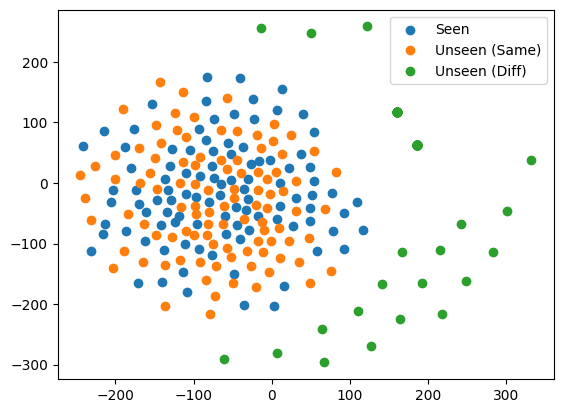

In [134]:
plt.scatter(tsne_output[:100, 0], tsne_output[:100, 1], label="Seen")
plt.scatter(tsne_output[100:200, 0], tsne_output[100:200, 1], label="Unseen (Same)")
plt.scatter(tsne_output[200:, 0], tsne_output[200:, 1], label="Unseen (Diff)")
plt.legend()

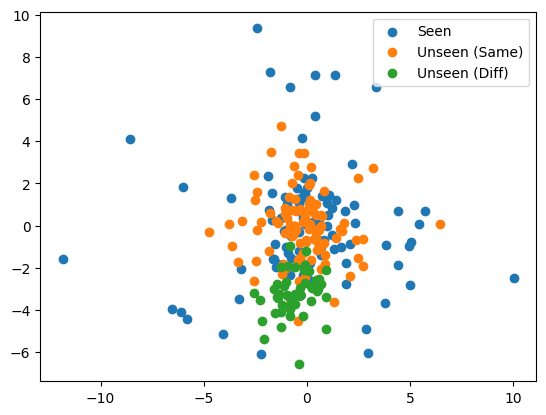

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(seen_tensor)

seen_pca = pca.transform(seen_tensor)
unseen_same_pca = pca.transform(unseen_same_tensor)
unseen_diff_pca = pca.transform(unseen_diff_tensor)

plt.scatter(seen_pca[:, 0], seen_pca[:, 1], label="Seen")
plt.scatter(unseen_same_pca[:, 0], unseen_same_pca[:, 1], label="Unseen (Same)")
plt.scatter(unseen_diff_pca[:, 0], unseen_diff_pca[:, 1], label="Unseen (Diff)")
plt.legend()